In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Import necessary libraries
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Step 1: Load the IMDB dataset
dataset = load_dataset('imdb')
train_data = dataset['train']
test_data = dataset['test']

# Step 2: Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Step 3: Define a tokenization function
def tokenize_data(data):
    return tokenizer(data['text'], padding='max_length', truncation=True, max_length=128)

# Apply tokenization to the dataset
train_data = train_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

# Step 4: Set the format of dataset for PyTorch
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Step 5: Load the BERT model for sequence classification
# GPU/CPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 정의 후 GPU로 이동
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)  # 모델을 GPU로 이동
print("GPU available:", torch.cuda.is_available())

# Step 6: Define evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Step 7: Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

# Step 9: Train the model
trainer.train()

# Step 10: Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Step 11: Save the trained model and tokenizer
model.save_pretrained('./sentiment-analysis-model')
tokenizer.save_pretrained('./sentiment-analysis-tokenizer')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU available: True


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.339000,0.343197,0.868080,0.859492,0.919340,0.806960
2,0.235300,0.418283,0.888480,0.888516,0.888232,0.888800
3,0.112900,0.554280,0.890600,0.891101,0.887039,0.895200


Evaluation results: {'eval_loss': 0.5542803406715393, 'eval_accuracy': 0.8906, 'eval_f1': 0.8911009356957993, 'eval_precision': 0.8870392390011891, 'eval_recall': 0.8952, 'eval_runtime': 184.9544, 'eval_samples_per_second': 135.168, 'eval_steps_per_second': 16.896, 'epoch': 3.0}


('./sentiment-analysis-tokenizer/tokenizer_config.json',
 './sentiment-analysis-tokenizer/special_tokens_map.json',
 './sentiment-analysis-tokenizer/vocab.txt',
 './sentiment-analysis-tokenizer/added_tokens.json',
 './sentiment-analysis-tokenizer/tokenizer.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained('/content/drive/MyDrive/sentiment-analysis-model')
tokenizer.save_pretrained('/content/drive/MyDrive/sentiment-analysis-tokenizer')


Mounted at /content/drive


('/content/drive/MyDrive/sentiment-analysis-tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment-analysis-tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment-analysis-tokenizer/vocab.txt',
 '/content/drive/MyDrive/sentiment-analysis-tokenizer/added_tokens.json',
 '/content/drive/MyDrive/sentiment-analysis-tokenizer/tokenizer.json')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/sentiment-analysis-model')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/sentiment-analysis-tokenizer')
trainer.train(resume_from_checkpoint=True)  # Trainer에서 체크포인트 활용


/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=9375, training_loss=0.0, metrics={'train_runtime': 0.0106, 'train_samples_per_second': 7052253.06, 'train_steps_per_second': 881531.633, 'total_flos': 4933332288000000.0, 'train_loss': 0.0, 'epoch': 3.0})

In [62]:
from transformers import AutoTokenizer

# 저장된 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# 텍스트와 라벨 복원
train_texts = [tokenizer.decode(x['input_ids'], skip_special_tokens=True) for x in train_data]
train_labels = [x['label'] for x in train_data]

# 결과 출력
print("첫 번째 텍스트:", train_texts[0])
print("첫 번째 라벨:", train_labels[0])


첫 번째 텍스트: i rented i am curious - yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u. s. customs if it ever tried to enter this country, therefore being a fan of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues
첫 번째 라벨: tensor(0)


In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# 텍스트 데이터 복원 및 라벨 추출
train_texts = [tokenizer.decode(x['input_ids'], skip_special_tokens=True) for x in train_data]
train_labels = [int(x['label']) for x in train_data]  # 라벨을 정수로 변환

test_texts = [tokenizer.decode(x['input_ids'], skip_special_tokens=True) for x in test_data]
test_labels = [int(x['label']) for x in test_data]  # 라벨을 정수로 변환

# Bag-of-Words 벡터화
vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Logistic Regression 학습
lr_model = LogisticRegression()
lr_model.fit(X_train, train_labels)

# 예측 및 평가
lr_predictions = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(test_labels, lr_predictions))
print("Classification Report:\n", classification_report(test_labels, lr_predictions))


Logistic Regression Accuracy: 0.79912
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     12500
           1       0.81      0.78      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


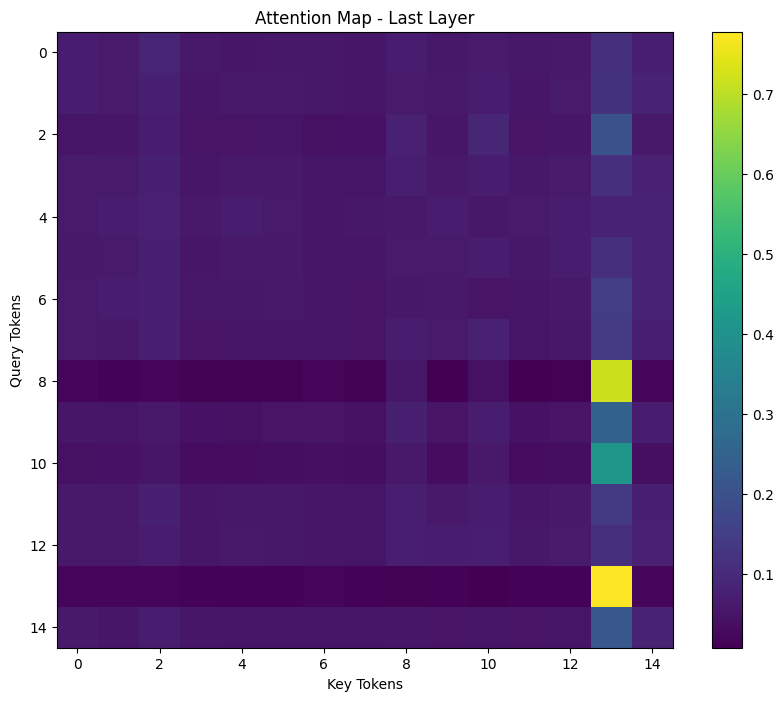

In [66]:
#attention map 시각화

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import torch


# Google Drive에 저장된 모델 및 토크나이저 경로
model_path = '/content/drive/MyDrive/sentiment-analysis-model'
tokenizer_path = '/content/drive/MyDrive/sentiment-analysis-tokenizer'

# 모델과 토크나이저 불러오기
model = AutoModelForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/sentiment-analysis-model',
    output_attentions=True
)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
# 샘플 텍스트
text = "This movie was absolutely fantastic. The plot and characters were amazing."

# 입력 데이터 준비
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

# 모델 출력 (Attention 반환 활성화)
with torch.no_grad():
    outputs = model(**inputs)

# Attention Map 추출 (마지막 Encoder Layer)
attentions = outputs.attentions  # List of Attention tensors
last_layer_attention = attentions[-1][0]  # 마지막 층의 첫 번째 Attention Map

# Attention Map 시각화
plt.figure(figsize=(10, 8))
plt.imshow(last_layer_attention[0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Attention Map - Last Layer")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()


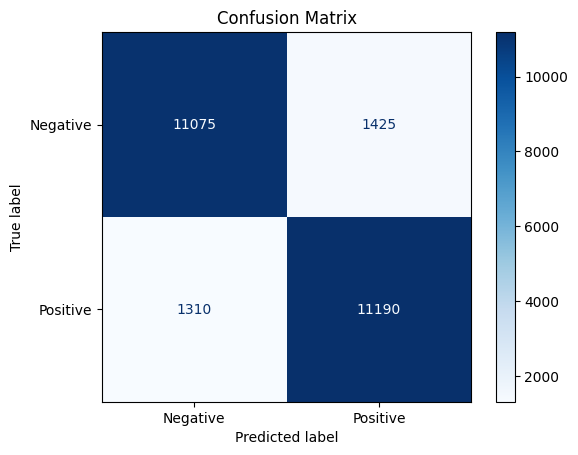

In [67]:
#혼동 행렬 시각

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 예측 및 라벨
predictions = trainer.predict(test_data)
y_true = predictions.label_ids  # 실제 라벨
y_pred = np.argmax(predictions.predictions, axis=1)  # 예측값

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


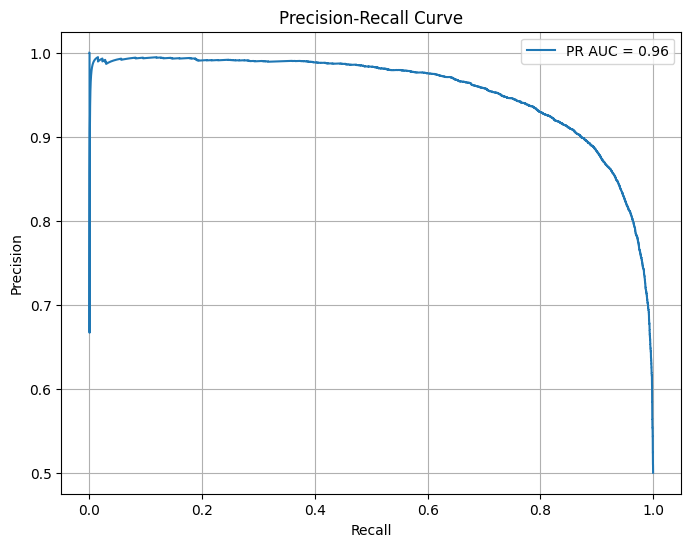

In [68]:
#precision-recall curve 시각화

from sklearn.metrics import precision_recall_curve, auc

# 모델 예측 점수
y_scores = predictions.predictions[:, 1]  # Positive 클래스 확률 추출
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

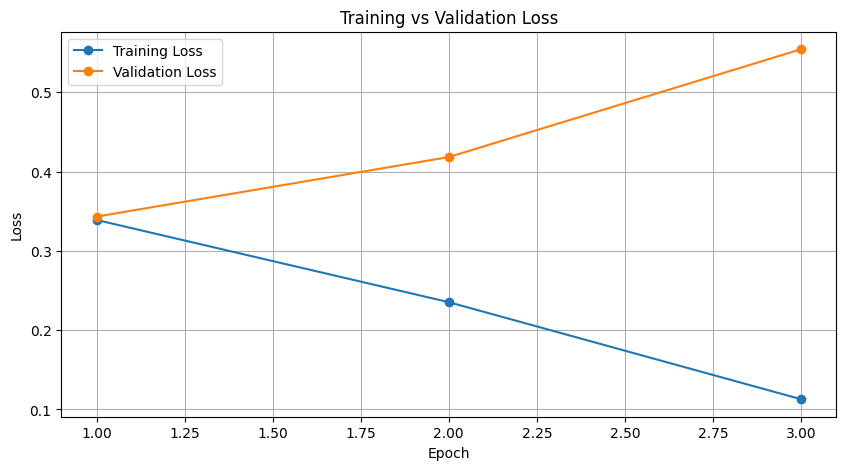

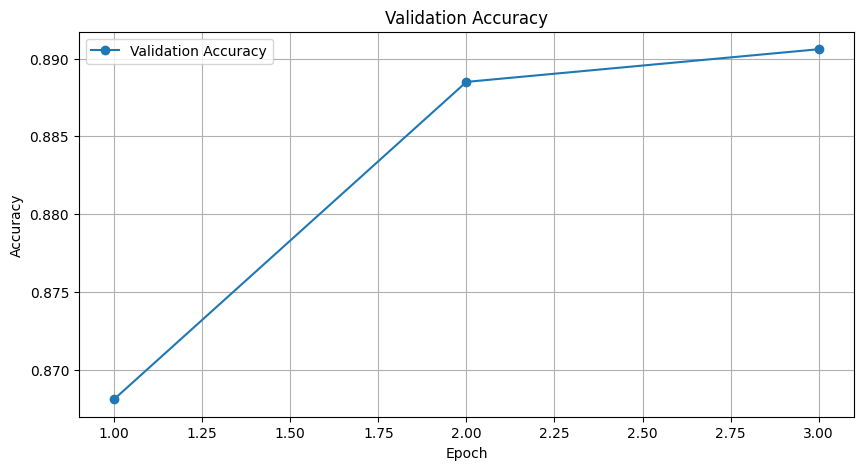

In [69]:
 #Validation Loss 및 Accuracy 그래프

# 에포크별 손실과 정확도
train_loss = [0.3390, 0.2353, 0.1129]
val_loss = [0.3432, 0.4183, 0.5543]
accuracy = [0.8681, 0.8885, 0.8906]

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, 4), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, 4), val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, 4), accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Future Direction 분석

# 잘못 분류된 샘플 추출
wrong_predictions = [
    (text, true, pred) for text, true, pred in zip(
        [tokenizer.decode(x['input_ids'], skip_special_tokens=True) for x in test_data],
        y_true,
        y_pred
    )
    if true != pred
]

# 상위 5개 잘못된 샘플 출력
for idx, (text, true, pred) in enumerate(wrong_predictions[:5]):
    print(f"Sample {idx + 1}")
    print(f"Text: {text}")
    print(f"True Label: {true}, Predicted Label: {pred}")
    print()


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/2024R0136COSE47402

/content/drive/MyDrive/Colab Notebooks/2024R0136COSE47402


In [ ]:
!git config --global user.email 'ghthd97@naver.com'
!git config --global user.name 'Freerider-song'

In [57]:
!git status

On branch master
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	FinalProject/Final_Project.ipynb
	"HW2/HW2_2017170858_\341\204\200\341\205\265\341\206\267\341\204\222\341\205\251\341\204\211\341\205\251\341\206\274.ipynb"

nothing added to commit but untracked files present (use "git add" to track)


In [58]:
!git add FinalProject/Final_Project.ipynb
!git commit -m "Final Project"


[master 98261a6] Final Project
 1 file changed, 1 insertion(+)
 create mode 100644 FinalProject/Final_Project.ipynb


In [59]:
!git push origin master

Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 16.89 KiB | 1.41 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/Freerider-song/2024R0136COSE47402.git
   5734a41..98261a6  master -> master
